In [ ]:
from scipy.spatial import distance as dist
import cv2
import csv
import numpy as np
from fastai import *
from fastai.vision import *
import pandas as pd
import argparse
import imutils
from imutils.video import FileVideoStream
import time
from imutils import face_utils
import dlib
from google.colab import drive
from google.colab.patches import cv2_imshow

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


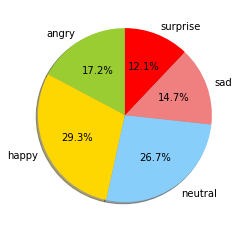

In [ ]:
import matplotlib.pyplot as plt

#Load test-classes from csv and print the distribution.
counter=0
reader = csv.reader(open('drive/MyDrive/VideoExpressions/subdata/csv_classes/classes.csv'))
classes_dict = {}
for row in reader:
    if counter!=0:
      key = row[0]
      classes_dict[key] = row[1]
    counter+=1

#0=angry, 1=happy, 2=neutral, 3=sad, 4=surprise
classes_stats=[0,0,0,0,0]
for key, value in classes_dict.items():
  if value=="angry":
    classes_stats[0]+=1
  if value=="happy":
    classes_stats[1]+=1
  if value=="neutral":
    classes_stats[2]+=1
  if value=="sad":
    classes_stats[3]+=1
  if value=="surprise":
    classes_stats[4]+=1
classes_list=[ 'angry', 'happy', 'neutral', 'sad' , 'surprise']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'red']

plt.pie(classes_stats, labels=classes_list, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

In [ ]:
#This is the path where all models are stored.
path = 'drive/MyDrive/VideoExpressions' 

#Load the pre-trained image classification model.
learn = load_learner(path, 'export.pkl')

#Load the pre-trained face detector from openCV.
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
#Load the pre-trained facial landmark detector from dlib.
predictor = dlib.shape_predictor("drive/MyDrive/VideoExpressions/shape_predictor_68_face_landmarks.dat")

In [ ]:
#Additional function used to calculate the Eye Aspect Ratio.
#Constant EYE_AR_THRESHidentify the EAR threshold (that indicates bliknking).
#Constant EYE_AR_CONSEC_FRAMES stores the threshold for the minimum consecutive frames the eye is below threshold (so that it is classified as a blink) can be modified according to the specific use case. In our case we emperically 

EYE_AR_THRESH = 0.24
EYE_AR_CONSEC_FRAMES = 3
def eye_aspect_ratio(eye):
	A = dist.euclidean(eye[1], eye[5])
	B = dist.euclidean(eye[2], eye[4])
	C = dist.euclidean(eye[0], eye[3])
	ear = (A + B) / (2.0 * C)
	return ear

In [75]:
#Function to perform a prediction on any given set of videos 
from statistics import mean

def test_realtime_class(directory, classes_list, showframes, iter_limit, save):

  all_results={}
  loopcounter=0
  for file in pathlib.Path(directory).iterdir():
      total_blinks=0
      blink_counter=0
      loopcounter+=1
      if loopcounter>iter_limit:  
        break
      if file.is_file():
        video_name=file.stem
        video_name_full=directory+"/"+video_name+file.suffix
        
        vidcap = FileVideoStream(video_name_full).start()
        count = 0
        framecount = 0
        data = []
        (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
        (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
       
        if save:
            out = cv2.VideoWriter(path + "/liveoutput"+video_name+".avi", cv2.VideoWriter_fourcc('M','J','P','G'), 10, (450,253))

        predictions_dict={
            "angry":{"all_class_pred":[], "frequency":0, "total_prob":0, "max_prob":0, "avg_prob_class":0, "avg_prob_total":0},
            "happy":{"all_class_pred":[], "frequency":0, "total_prob":0, "max_prob":0, "avg_prob_class":0, "avg_prob_total":0},
            "neutral":{"all_class_pred":[], "frequency":0, "total_prob":0, "max_prob":0, "avg_prob_class":0, "avg_prob_total":0},
            "sad":{"all_class_pred":[], "frequency":0, "total_prob":0, "max_prob":0, "avg_prob_class":0, "avg_prob_total":0},
            "surprise":{"all_class_pred":[], "frequency":0, "total_prob":0, "max_prob":0, "avg_prob_class":0, "avg_prob_total":0}
        }

        while vidcap.more():
            frame = vidcap.read()
            if frame is None:
                break
            frame = imutils.resize(frame, width=450)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            face_coord = face_cascade.detectMultiScale(gray, 1.1, 20, minSize=(30, 30))
            for coords in face_coord:
                X, Y, w, h = coords
                H, W, _ = frame.shape
                X_1, X_2 = (max(0, X - int(w * 0.3)), min(X + int(1.3 * w), W))
                Y_1, Y_2 = (max(0, Y - int(0.3 * h)), min(Y + int(1.3 * h), H))
                img_cp = gray[Y_1:Y_2, X_1:X_2].copy()
                rect = dlib.rectangle(X, Y, X+w, Y+h)
                shape = predictor(gray, rect)
                shape = face_utils.shape_to_np(shape)

                # extract the left and right eye coordinates, then use the coordinates to compute the eye aspect ratio for both eyes
                leftEye = shape[lStart:lEnd]
                rightEye = shape[rStart:rEnd]
                leftEAR = eye_aspect_ratio(leftEye)
                rightEAR = eye_aspect_ratio(rightEye)
                
                # average the eye aspect ratio together for both eyes
                ear = (leftEAR + rightEAR) / 2.0

                # compute the convex hull for the left and right eye, then visualize each of the eyes
                leftEyeHull = cv2.convexHull(leftEye)
                rightEyeHull = cv2.convexHull(rightEye)
                cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
                cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

                if ear < EYE_AR_THRESH:
                    blink_counter += 1
                    if blink_counter >= EYE_AR_CONSEC_FRAMES:
                        cv2.putText(frame, "Blinking", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                        total_blinks+=1
                        blink_counter=0 #reset counter when one blink is registered
                
                cv2.putText(frame, "Eye Ratio: {:.2f}".format(ear), (250, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                          
                prediction, idx, probability = learn.predict(Image(pil2tensor(img_cp, np.float32).div_(225)))
                data.append([framecount, prediction, probability, ear])
                cv2.rectangle(
                        img=frame,
                        pt1=(X_1, Y_1),
                        pt2=(X_2, Y_2),
                        color=(128, 128, 0),
                        thickness=2,
                    )
                max_probability=float(max(probability))

                cv2.putText(frame, str(prediction),   (10, frame.shape[0] - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                predictions_dict[classes_list[0]]["all_class_pred"].append(float(probability[0]))
                predictions_dict[classes_list[1]]["all_class_pred"].append(float(probability[1]))
                predictions_dict[classes_list[2]]["all_class_pred"].append(float(probability[2]))
                predictions_dict[classes_list[3]]["all_class_pred"].append(float(probability[3]))
                predictions_dict[classes_list[4]]["all_class_pred"].append(float(probability[4]))

                predictions_dict[str(prediction)]["frequency"]=predictions_dict[str(prediction)]["frequency"]+1
                predictions_dict[str(prediction)]["total_prob"]=predictions_dict[str(prediction)]["total_prob"]+max_probability
                if (predictions_dict[str(prediction)]["max_prob"]<max_probability):
                  predictions_dict[str(prediction)]["max_prob"]=max_probability
            
            cv2.putText(frame, "P={:.2f}".format(max_probability), (10, frame.shape[0] - 45), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (204, 255, 155), 2)
            if showframes:
              cv2_imshow(frame)
              
            framecount += 1
            if save:
              out.write(frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
              break
        if save:
          print("Saving video output complete.")
          out.release()
        cv2.destroyAllWindows()
        #after all frames are iterated calculated score according to weighted AVG score method      
        max_score=0
        max_pred_class="null"
        new_avg_prob_class=0
        new_avg_prob_total=0
        class_score=0

        for pred_class in predictions_dict:
          if predictions_dict[pred_class]["frequency"]!=0:
            new_avg_prob_class=predictions_dict[pred_class]["total_prob"]/predictions_dict[pred_class]["frequency"]
          if framecount!=0:
            new_avg_prob_total=predictions_dict[pred_class]["total_prob"]/framecount
          class_score=new_avg_prob_class*new_avg_prob_total

          predictions_dict[pred_class]["avg_prob_class"]=new_avg_prob_class
          predictions_dict[pred_class]["avg_prob_total"]=new_avg_prob_total
          if class_score>max_score:
            max_score=class_score
            max_pred_class=pred_class
      
        all_results[video_name]={"true_class":classes_dict[video_name], "predicted_wavg":max_pred_class,"predicted_wavg_score":max_score,  "eye_blinks":total_blinks, "framecount":framecount}
  return(all_results)        

In [ ]:
#Execute the above function for all test videos from MOSEI. Store the results in a dictionary.
directory = 'drive/MyDrive/VideoExpressions/subdata'
classes_list=['angry', 'happy', 'neutral', 'sad' , 'surprise']
showframes=False
iter_limit=10000
save=False
all_results=test_realtime_class(directory,classes_list, showframes, iter_limit, save)

In [ ]:
#Loop over dictionary, store values in arrays and print results.
true_classarr=[]
pred_classarr=[]
print(all_results)
for video in all_results:
  
  predicted_class=all_results[video]["predicted_wavg"]  
  true_class= all_results[video]["true_class"]
  #Skip any video for which no prediction exists. Usually this will happen if the video did not contain any faces.
  if not(predicted_class=='null'):
    print("=======================================================================================================================================")
    true_classarr.append(true_class)

    pred_classarr.append(predicted_class)

    print("Video name is: ", video)
    print("Actual class is: ", all_results[video]["true_class"])
    print("Predicted class is: ", predicted_class, " with final_score:", all_results[video]["predicted_wavg_score"])
    print("Number of blinks: ", all_results[video]["eye_blinks"])

{'vid_861': {'true_class': 'happy', 'predicted_wavg': 'happy', 'predicted_wavg_score': 0.5980542691420337, 'eye_blinks': 9, 'framecount': 71}, 'vid_124': {'true_class': 'neutral', 'predicted_wavg': 'neutral', 'predicted_wavg_score': 0.784353680661991, 'eye_blinks': 0, 'framecount': 29}, 'vid_1790': {'true_class': 'neutral', 'predicted_wavg': 'neutral', 'predicted_wavg_score': 0.15691166153697161, 'eye_blinks': 15, 'framecount': 181}, 'vid_783': {'true_class': 'sad', 'predicted_wavg': 'sad', 'predicted_wavg_score': 0.3581702286833241, 'eye_blinks': 57, 'framecount': 316}, 'vid_758': {'true_class': 'sad', 'predicted_wavg': 'sad', 'predicted_wavg_score': 0.4055718836424073, 'eye_blinks': 6, 'framecount': 43}, 'vid_240': {'true_class': 'neutral', 'predicted_wavg': 'neutral', 'predicted_wavg_score': 0.23551665035036515, 'eye_blinks': 19, 'framecount': 59}, 'vid_862': {'true_class': 'happy', 'predicted_wavg': 'happy', 'predicted_wavg_score': 0.54161991529439, 'eye_blinks': 15, 'framecount': 

              precision    recall  f1-score   support

       angry       1.00      0.53      0.69        19
       happy       0.68      0.88      0.77        34
     neutral       0.65      0.71      0.68        31
         sad       0.56      0.62      0.59        16
    surprise       1.00      0.57      0.73        14

    accuracy                           0.70       114
   macro avg       0.78      0.66      0.69       114
weighted avg       0.75      0.70      0.70       114



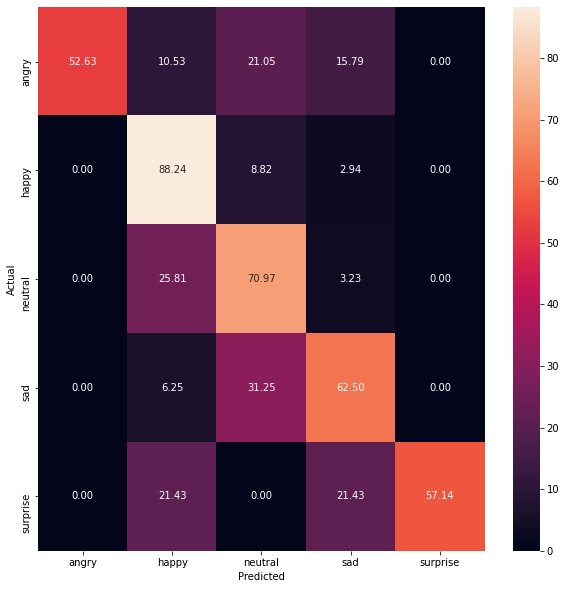

In [ ]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Printing the precision and recall, among other metrics
print(metrics.classification_report(true_classarr, pred_classarr, labels=[ 'angry', 'happy', 'neutral', 'sad' , 'surprise']))
cm = confusion_matrix(true_classarr, pred_classarr)

# Normalized confusion matrix
cmn = (cm.astype('float')/cm.sum(axis=1)[:, np.newaxis])*100
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=[ 'angry', 'happy', 'neutral', 'sad' , 'surprise'], yticklabels=[ 'angry', 'happy', 'neutral', 'sad' , 'surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

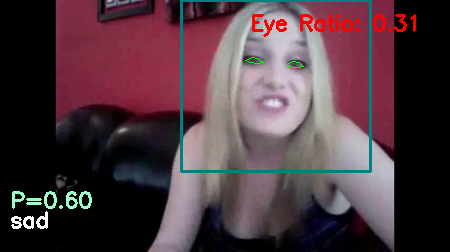

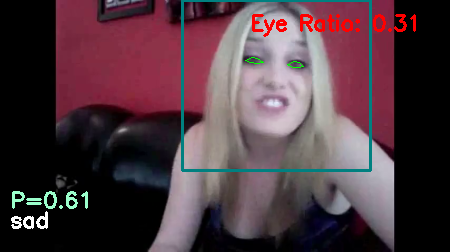

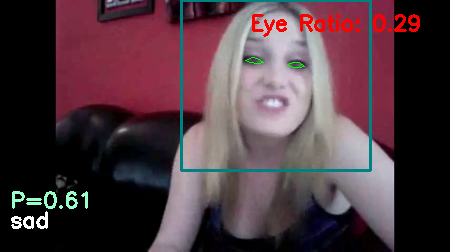

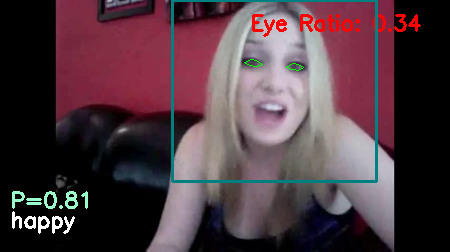

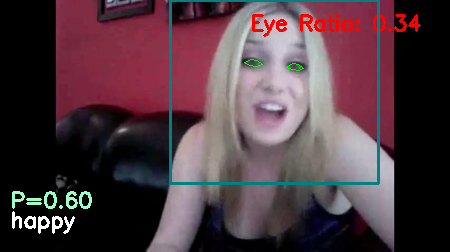

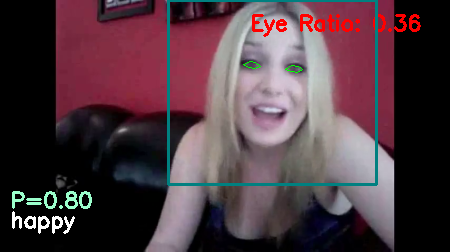

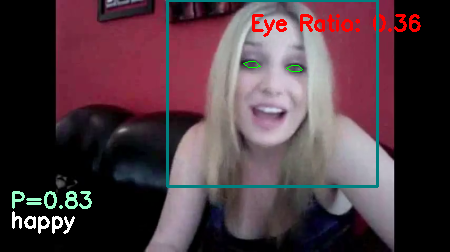

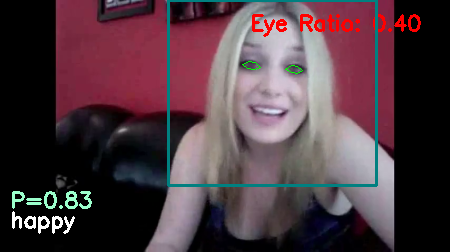

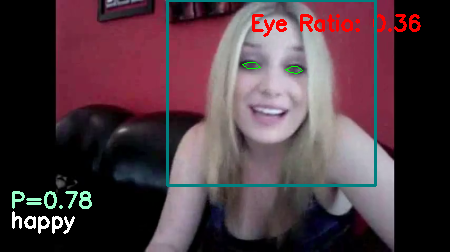

Saving video output complete.


{'vid_628': {'eye_blinks': 0,
  'framecount': 9,
  'predicted_wavg': 'happy',
  'predicted_wavg_score': 0.4016773527626407,
  'true_class': 'happy'}}

In [74]:
#Show a demo with output and eye-blinking features. Save the output to a video .avi file.

directory = 'drive/MyDrive/VideoExpressions/subdata/demos'
classes_list=['angry', 'happy', 'neutral', 'sad' , 'surprise']
showframes=True
iter_limit=3
save=True
test_realtime_class(directory,classes_list, showframes, iter_limit, save)